# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime
import openweathermapy.core as owm 
import os
import urllib

# Import API key
from api_keys import api_key 

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
countries = []
keys = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country_code = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    
    # create key for cities with the same name to use in API call (e.g. Athens GR vs Athens GA, Albany NY vs Albany AU)
    key = city+', '+country_code 

    # If the city key is unique, then add it to our keys list (and do the same for the countries and cities)
    if key not in keys:
        cities.append(city)
        countries.append(country_code)
        keys.append(key)

# Print the city count to confirm sufficient count
print(len(keys))


613


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
weather = []
i=1

try: os.mkdir('output')
except: pass

log = os.path.join("output/log.txt")
with open(log, 'w') as textfile:
    
    settings = {"units": "imperial", "appid": api_key}
    for key in keys:
        
        try:
            cityweather = owm.get_current(key, **settings)
            textfile.write(f"Processing record {i}: {cityweather['name']}, ID: {cityweather['id']} \n")        
        
        except urllib.request.HTTPError as e:
            if e.code == 429:
                textfile.write(f"Processing record {i}: {key}, {e}. Retrying in 61 sec\n")
                time.sleep(61)
                cityweather = owm.get_current(key, **settings)
                textfile.write(f"Processing record {i}: {cityweather['name']}, ID: {cityweather['id']} \n")
            elif e.code == 404:
                textfile.write(f"{key} not found. Skipping City...\n")
                continue
            else:
                textfile.write(f"{e} Skipping {key}...\n")
                continue

        except BaseException as e:
                textfile.write(f"{e} Skipping {key}...\n")
                continue

        weather += [{'City':cityweather['name'],
                     'Country':cityweather['sys']['country'],
                     'City ID': cityweather['id'],
                     'Latitude':cityweather['coord']['lat'],
                     'Longditude':cityweather['coord']['lon'],
                     'Cloudiness':cityweather['clouds']['all'],
                     'Humidity':cityweather['main']['humidity'],
                     'Current Temp':cityweather['main']['temp'],
                     'Max Temp':cityweather['main']['temp_max'],
                     'Min Temp':cityweather['main']['temp_min'],
                     # take avg to normalize for different time zones 
                     'Avg Temp':(cityweather['main']['temp_max']+cityweather['main']['temp_min'])/2,
                     'Wind Speed':cityweather['wind']['speed']
                    }]
        i += 1

with open(log, 'r') as textfile:                       
    print(textfile.read())
textfile.close()

Processing record 1: Cidreira, ID: 3466165 
Processing record 2: Rafsanjan, ID: 118994 
Processing record 3: Quatre Cocos, ID: 1106643 
Processing record 4: Padang, ID: 1633419 
mataura, pf not found. Skipping City...
Processing record 5: Lusambo, ID: 210379 
airai, pw not found. Skipping City...
Processing record 6: Ushuaia, ID: 3833367 
Processing record 7: Dikson, ID: 1507390 
Processing record 8: Atuona, ID: 4020109 
Processing record 9: Geraldton, ID: 2070998 
Processing record 10: Rikitea, ID: 4030556 
yaan, cn not found. Skipping City...
Processing record 11: Hithadhoo, ID: 1282256 
Processing record 12: Kapaa, ID: 5848280 
Processing record 13: Guatire, ID: 3639898 
Processing record 14: Fortuna, ID: 5563839 
Processing record 15: Khatanga, ID: 2022572 
Processing record 16: Karratha, ID: 6620339 
Processing record 17: Sao Gabriel da Cachoeira, ID: 3662342 
lolua, tv not found. Skipping City...
Processing record 18: Korla, ID: 1529376 
illoqqortoormiut, gl not found. Skipping C

In [5]:
# Print new city count after lookup to confirm the count remains sufficient (to account for API calls not returned)
print(len(weather))

523


In [6]:
# Create DataFrame
weather_df = pd.DataFrame(weather)

# Change order of Columns
weather_df = weather_df[['City', 
                         'Country', 
                         'City ID',
                         'Latitude', 
                         'Longditude', 
                         'Cloudiness', 
                         'Humidity', 
                         'Current Temp', 
                         'Max Temp', 
                         'Min Temp', 
                         'Avg Temp', 
                         'Wind Speed']]

# Export the city data into a .csv
weather_df.to_csv("output/weather.csv")

# Display the DataFrame
weather_df.head()

,City,Country,City ID,Latitude,Longditude,Cloudiness,Humidity,Current Temp,Max Temp,Min Temp,Avg Temp,Wind Speed
0,Cidreira,BR,3466165,-30.17,-50.22,44,91,62.01,62.01,62.01,62.010,1.30
1,Rafsanjan,IR,118994,30.40,55.99,56,25,50.62,50.62,50.62,50.620,4.21
2,Quatre Cocos,MU,1106643,-20.21,57.76,75,74,85.53,86.00,84.99,85.495,17.22
3,Padang,ID,1633419,-0.92,100.36,40,79,84.20,84.20,84.20,84.200,4.70
4,Lusambo,CD,210379,-4.97,23.44,92,93,72.36,72.36,72.36,72.360,2.86


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

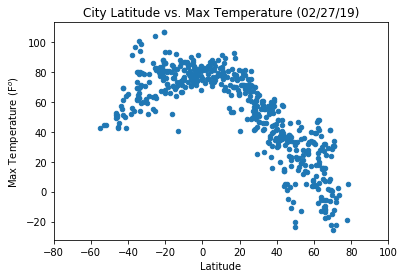

In [23]:
date = datetime.datetime.now().strftime("%x")

weather_df.plot (kind='scatter', x='Latitude', y='Max Temp', 
                 title=f'City Latitude vs. Max Temperature ({date})', xlim=(-80,100))
plt.ylabel(f'Max Temperature (F$^o$)')

plt.savefig("output/Lat-T.png")

plt.show()

#### Latitude vs. Humidity Plot

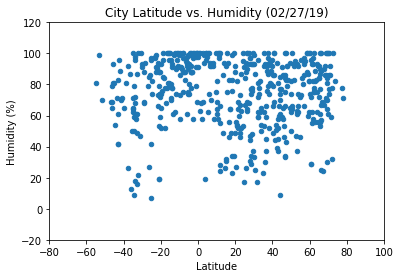

In [24]:
weather_df.plot (kind='scatter', x='Latitude', y='Humidity',
                 title=f'City Latitude vs. Humidity ({date})', xlim=(-80,100), ylim=(-20,120))
plt.ylabel('Humidity (%)')
plt.show()

#### Latitude vs. Cloudiness Plot

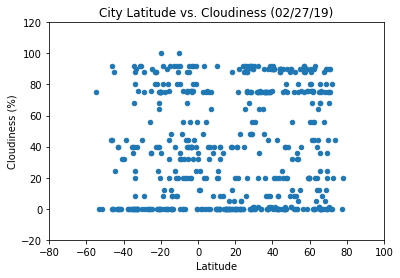

In [9]:
weather_df.plot (kind='scatter', x='Latitude', y='Cloudiness',
                 title=f'City Latitude vs. Cloudiness ({date})', xlim=(-80,100), ylim=(-20, 120))
plt.ylabel('Cloudiness (%)')

plt.savefig("output/Lat-Cl.png")

plt.show()

#### Latitude vs. Wind Speed Plot

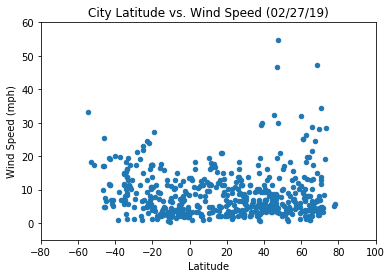

In [10]:
weather_df.plot (kind='scatter', x='Latitude', y='Wind Speed',
                 title=f'City Latitude vs. Wind Speed ({date})', xlim=(-80,100), ylim=(-5,60))
plt.ylabel('Wind Speed (mph)')

plt.savefig("output/Lat-Wind.png")

plt.show()

## Observable Trends
- Generally speaking temperature increases the closest we are to the equator as expected. However there are some peak points in the -20 to -40 latitude range, that are even higher than the points close to the equator. Considering that this is summer in the southern hemisphere, this should represent desert areas where the temperature peaks higher, while most areas close to the equator have a more steady temperature throughout the year. I did look up the temperatures over 100F in the data set and all 4 of them are in Australia so this confirms this assumption, therefore eliminating the need to exclude any points as outliers.
- There doesn't seem to be a strong correlation between latitude and humidity. It was noted however that there is a slightly higher concentration of high humidity points in the -20 to 0 latitude area, while low himidity is practically non existant in that range. This seems reasonable considering that this corresponds to areas of Affrica, South America and Indonesia where jungles are prevelant without deserts. 
- There doesn't seem to be a strong correlation between latitude and wind speed. However it was noted that there were no high winds recorded close to the equator. Also there are more cases of high speed in the northern than the southern hemisphere, which is reasonable considering it's winter in the northern hemisphere this time of the year.
- One limitation of the current analysis is that we don't consider the weather above water. Considering there is significantly more land in the northern heimsphere, but our selection was done by choosing coordinates randomly and then looking at the nearest city, this means that southern hemisphere selection was more concerntrated from fewer areas. Also there should be more cases there where the nearest city is quite far away from the random coordinates selected originally. 